<div style='font-size: 1.3em;'><h1 >Metrics to evaluate Virtual Screening Performance
</h1>
    </div>

**This notebook briefly describes and synthesizes different metrics to evaluate the Virtual Screening performance of a specific methodology (e.g., some docking tool). These metrics are the following:**

<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>AUAC</span>:<i>Area Under Accumulation Curve</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #F5B75D; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>AUC-ROC</span>:<i>Area Under the Curve of Receiver Operating Characteristic</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Precision and Recall Trade-off</span> and <i>Area Under the Precision and Recall Curve</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Enrichment Factor</span> and <i>Area Under the Normalized Enrichment Factor (NEF) Curve</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE9060; padding: 5px;'>5)</span>
     <span style='font-weight: bold;'>RIE</span>: <i>Robust Initial Enhancement</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>6)</span>
     <span style='font-weight: bold;'>BEDROC</span>: <i>Boltzmann-Enhancement Discrimination of the Receiver Operating Characteristic</i>.
    </li>
</ol>

Most of these metrics were reviewed by [Truchon y Bayley (2007)](https://pubs.acs.org/doi/10.1021/ci600426e).

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append(r'..')

In [2]:
from modules.plotting_metrics import PlotMetric
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.subplots_adjust(wspace=0.3);

<Figure size 432x288 with 0 Axes>

### Carga de los resultados de Docking para CSAR y DUD

In [3]:
data_dir = '../data/docking_scores'
# Resultados CSAR
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
df_vina_results   = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
df_vinardo_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)
# Resultados DUD

df_vinardo_DUD = pd.read_csv(F'{data_dir}/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv', index_col=0)

In [4]:
# Estos scores son para ejemplificar la ejecución de las métricas
pdb_id = '1ckp'
y_score_vrd = np.array(df_vinardo_results[pdb_id])
y_score_vina = np.array(df_vina_results[pdb_id])
y_score_ad4_LE = np.array(df_ad4_results_LE[pdb_id])
y_score_ad4_LC = np.array(df_ad4_results_LC[pdb_id])
scores_csar = {"AD4 LE": y_score_ad4_LE, "AD4 LC": y_score_ad4_LC, 
               "Vina": y_score_vina, "Vinardo": y_score_vrd}

In [5]:
file_dud_ligef = F'../data/docking_scores/vs_dk_CRYS_402_DUD2006_VINARDO_ligand_Efficiency.csv'
df_vinardo_DUD_LigEff = pd.read_csv(file_dud_ligef, index_col=0)

In [6]:
pdb_id_dud= '1ckp'
y_score_vrd_DUD = np.array(df_vinardo_DUD[pdb_id_dud])
y_score_vrd_DUD_LigEff = np.array(df_vinardo_DUD_LigEff[pdb_id_dud])
scores_dud = {'VinardoDUD': y_score_vrd_DUD}
              #, 'VinardoDUD_LigEff': y_score_vrd_DUD_LigEff} # Removed for simplicity

### Los tres casos mencionados por Truchon y Bayly

- **Caso 1**: La mitad de los activos se ubica al principio del *ranking*, mientras que la otra mitad se encuentra al final.
- **Caso 2**: Todos los activos se distribuyen justo a la mitad del ranking.
- **Caso 3**: Los activos e inactivos se encuentran uniformemente distribuidos.

### Casos aplicados a los datasets de CSAR y DUD para la proteína CDK2

**CSAR**:
> CSAR posee 111 moléculas, de las cuales 26 son activas, con lo cual el $R_a$ de CSAR es de $26/111 = 2.36$.

In [7]:
N_csar = 111
n_csar = 26
# Creamos el arreglo de valores verdaderos:
y_true_csar = np.array(df_vina_results.ActiveInactive == "Active", dtype=int)
# Scores obtenidos con las herramientas de docking
csar_dockings = PlotMetric(y_true = y_true_csar, y_pred_dict = scores_csar, decreasing=True)

**DUD:**
> DUD posee  2146 moléculas de las cuales 72 son activas; $R_a = 72/2146 = 0.033$.

In [8]:
N_dud = 2146
n_dud = 72
y_true_dud = np.array(df_vinardo_DUD.Actividad == "Active", dtype=int)
# Scores obtenidos con las herramientas de docking
dud_dockings = PlotMetric(y_true = y_true_dud, y_pred_dict = scores_dud, decreasing=True)

Las variables `y_true_csar` y `y_true_dud` corresponden a un arreglo binario de $N$ elementos que corresponden al número total de moléculas, donde las moléculas activas son etiquetadas con le valor $1$ y las inactivas con $0$. El número totoal de moléculas activas en cada arreglo es $n$.

### Generación de los valores predichos para simular los tres casos de ranking

In [9]:
from truchon_2006_3_ranking_cases import get_three_ranking_cases

#### Casos aplicados a CSAR

In [10]:
# Generamos los tres casos de CSAR
csar_cases_preds = get_three_ranking_cases(y_true_csar, include_optimal = True)
csar_cases = PlotMetric(y_true = y_true_csar, y_pred_dict = csar_cases_preds)
csar_cases_preds['Case 1']

array([-3., -3., -3., -3., -2., -3., -3., -3., -3., -3., -3., -3., -3.,
       -3., -1., -1., -1., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -2.,
       -2., -2., -2., -2., -2., -2., -2., -2., -2., -2., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.])

#### Casos aplicados a DUD

In [11]:
dud_cases_preds = get_three_ranking_cases(y_true_dud, include_optimal = True)
dud_cases = PlotMetric(y_true = y_true_dud, y_pred_dict = dud_cases_preds)

### Visualización de las distribuciones en CSAR
#### Visualizamos la distribución de los activos en los tres casos de Truchon y Bayly
Cada barra representa un ranking correspondiente a cada caso, en color rojo se muestran los ligandos activos (verdaderos positivos).

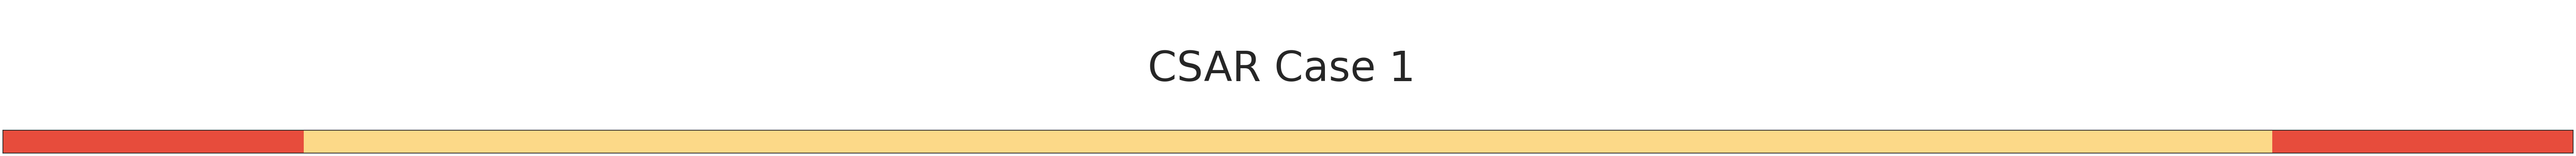

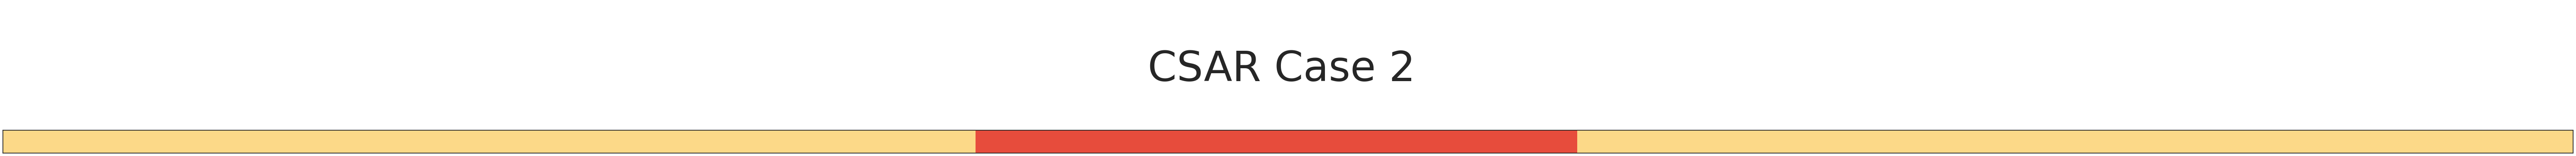

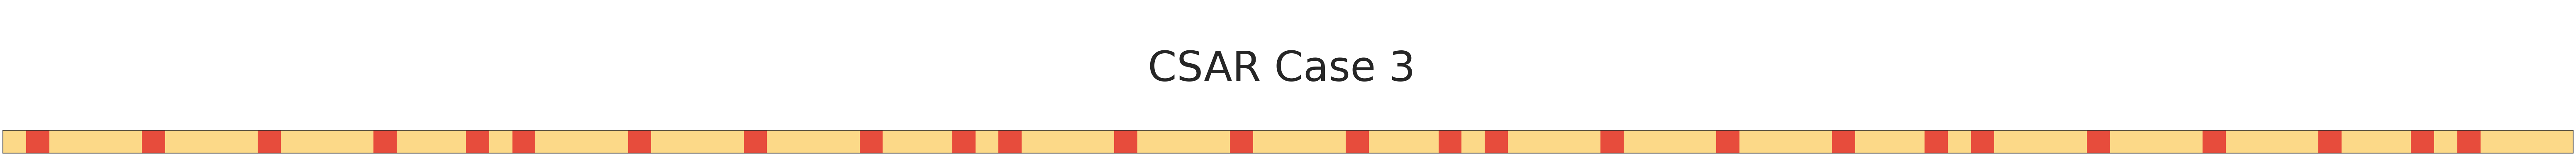

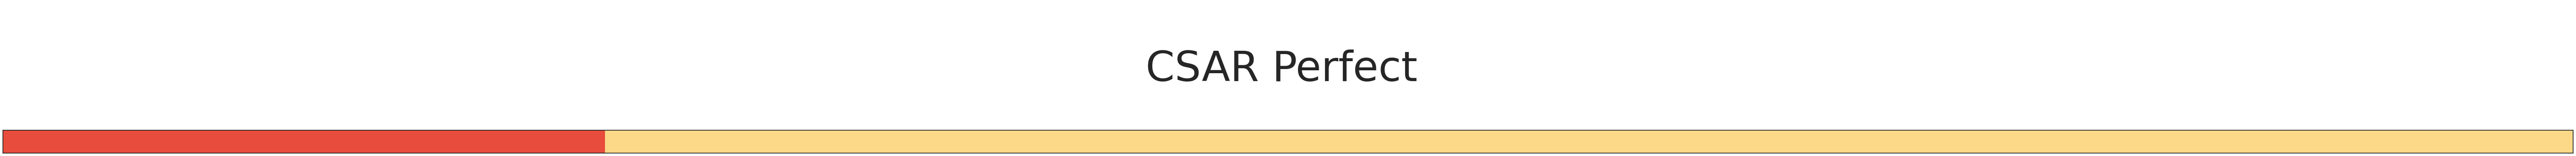

In [12]:
# Visualización de los rankings en CSAR
csar_cases.plot_actives_distribution(add_to_title='CSAR')

#### Visualización de la distribución de activos según cada ranking de los scores de docking

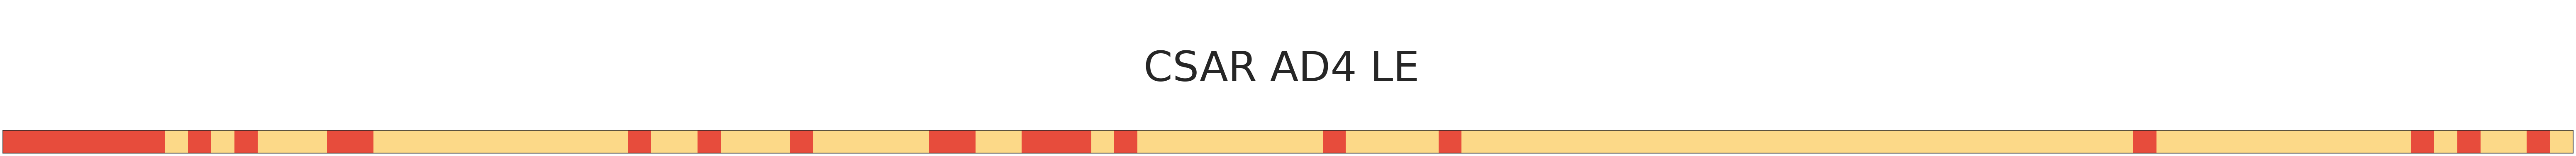

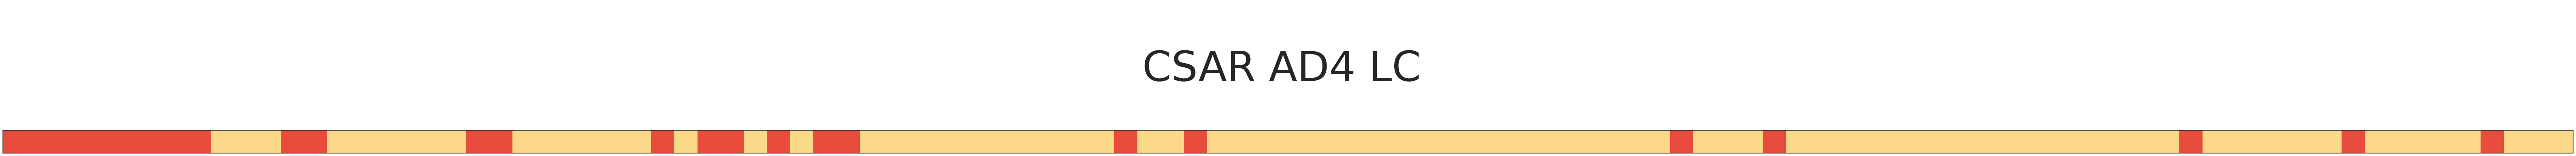

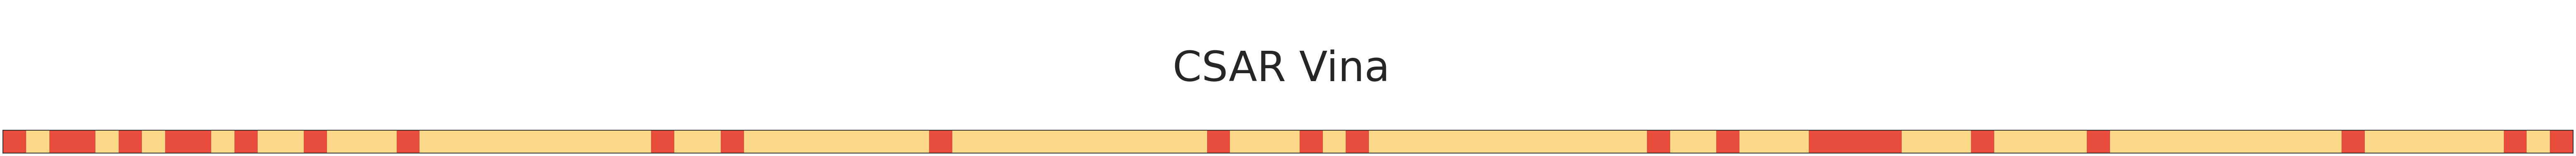

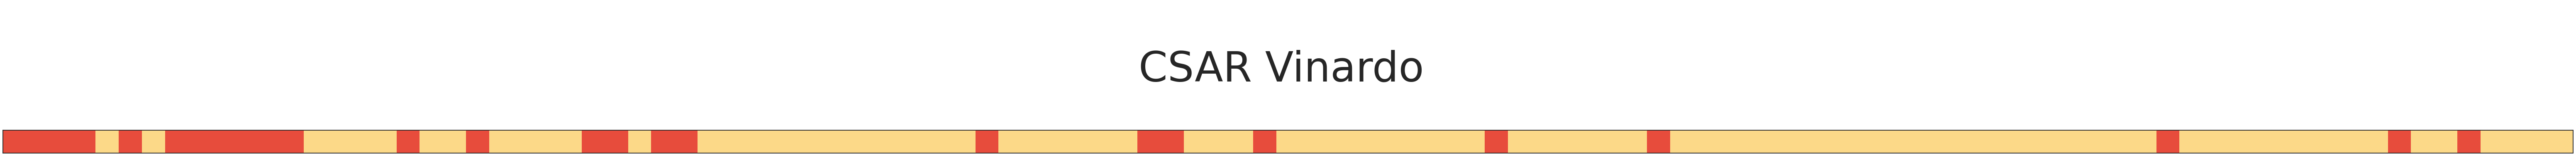

In [13]:
# Visualización de los rankings en CSAR
csar_dockings.plot_actives_distribution(add_to_title='CSAR')

### Visualización de las primeras 100 posiciones en el ranking de <span style='color: red'>DUD con Vinardo</span>
#### Resultados de docking  de DUD con Vinardo

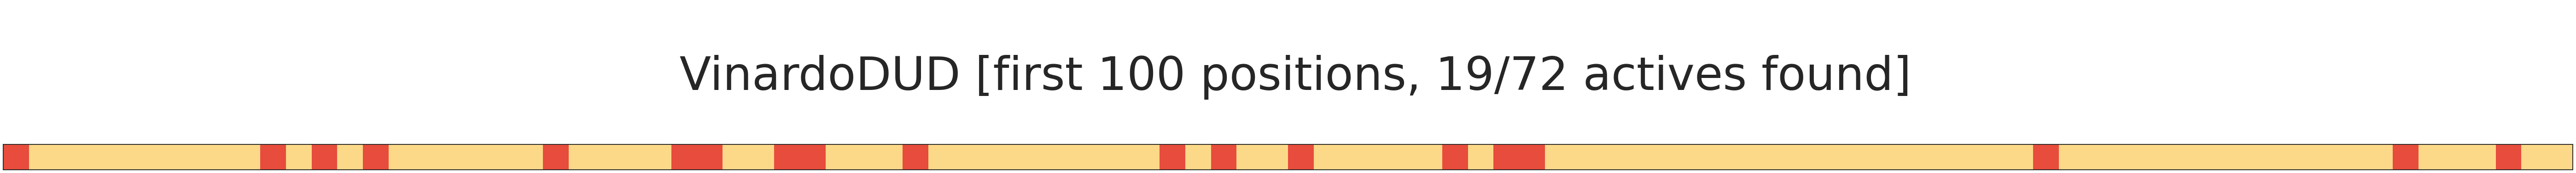

In [14]:
dud_dockings.plot_actives_distribution(max_position_to_plot=100)

#### 3 casos de Truchon & Bayly (DUD)

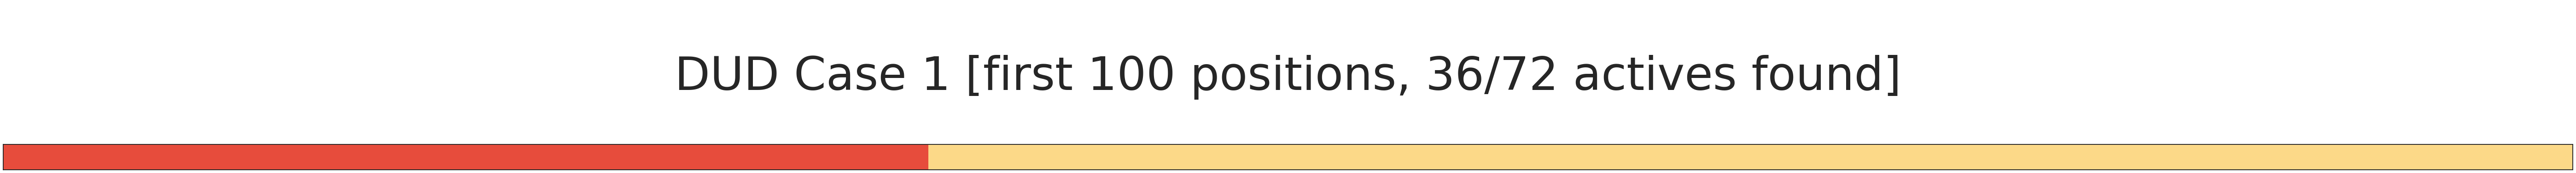

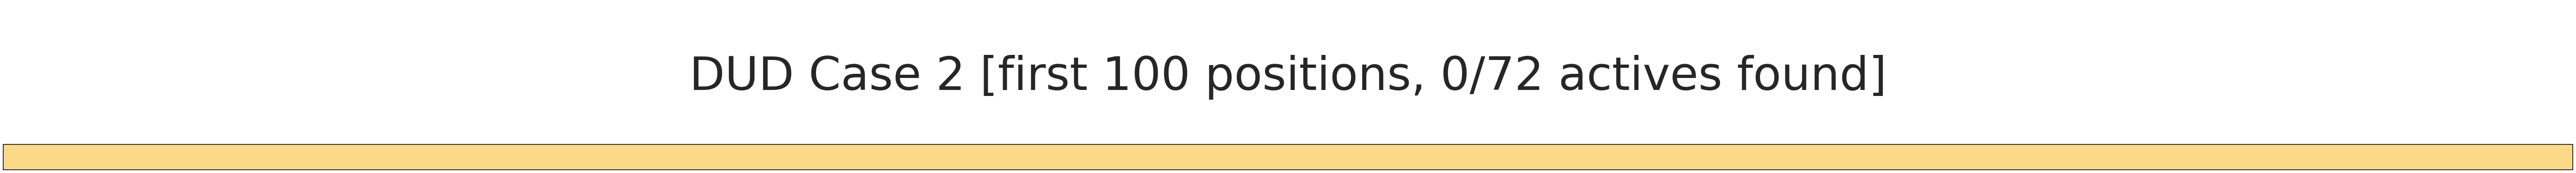

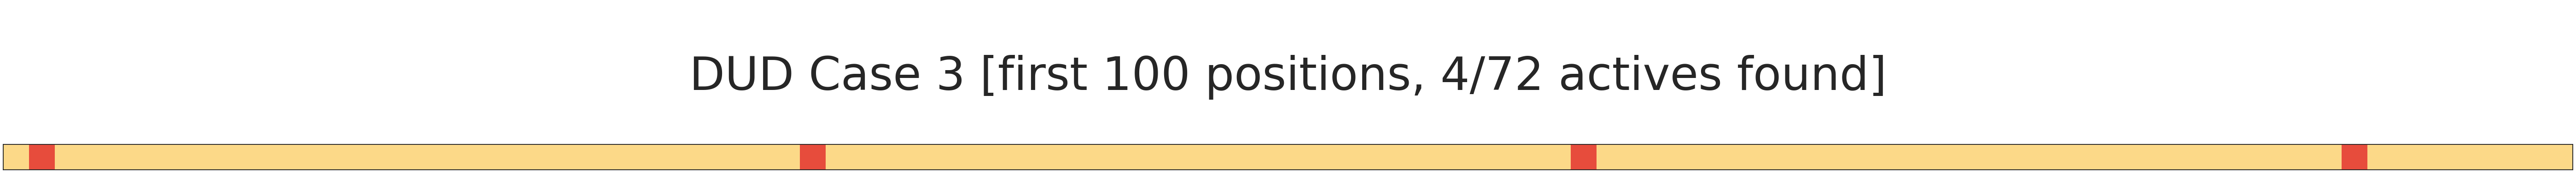

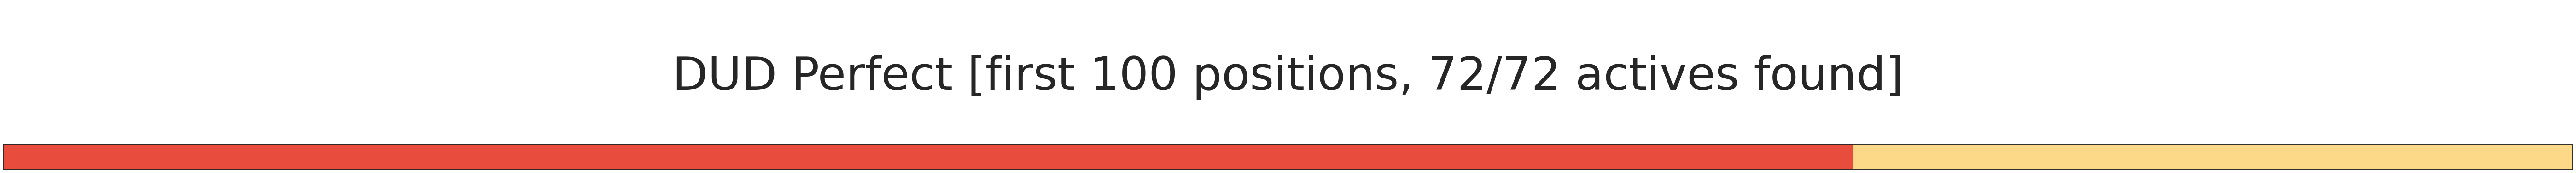

In [15]:
dud_cases.plot_actives_distribution(max_position_to_plot=100, add_to_title='DUD')

**NOTA**: No se muestra la visualización de DUD debido al número de moléculas en el dataset genera una imagen demasiado grande y no puede ser mostrada dentro de este notebook.

### Notación inicial:

Los rankings de las moléculas obtenidos por una herramienta o método de scoring determinan una función de distribución de probabilidad (PDF) $f(x)$, a partir de ella se obtiene la función de distribución acumulada (CDF) $F(x)$, con lo cual: $F(x) = \int_{0}^{1} f(x)dx$.

La distribución de los activos en el *ranking* dado, y la $CDF$ del mismo, permiten a las métricas presentadas a continuación valorar el desempeño de la herramienta que generó el *ranking*.

- $N$: Número total de moléculas
- $n$: Número de moléculas activas
- $R_a = n/N$: Proporción de activos en el ranking k
- $k = (k_1, k_2, ..., k_N)$: Lista de scores ordenados, donde la posición $k_i$ corresponde al mejor score.
- $x = k/N = (x_1, x_2, ..., x_N)$: Lista normalizada del ranking $k$.

***

<h1 class='text-danger'>AUAC: <span class="text-muted">Area Under the Accumulation Curve</span>
</h1><div style='background-color: #F9E5AB; min-height: 10px'></div>

- La curva de **Acumulación equivale a la función de distribución acumulada (CDF) de los activos** en el *ranking* normalizado; $F_a(x)$.
- <span class="p-3 mb-2 bg-danger text-white">$F_a(x)$ corresponde a la probabilidad de encontrar una molécula activa a una posición $x_i$ del ranking normalizado $x$. Es decir, corresponde a la sensibilidad ($TP/P$) acumulada hasta la posición $k_i$.</span>
- $AUAC$ es el área bajo la curva de $F_a(x)$ en función de ($x$), con lo cual:

$$
\begin{aligned}
AUAC = \int _{0}^{1} F_a(x)
\end{aligned}
$$

- 

<div style='background-color: #C6FCDE; padding: 5px 12px;'>$AUAC$ se puede interpretar como la probabilidad de que un activo, seleccionado de una CFD (definida por el ranking), sea rankeado antes de una molécula seleccionada aleatoriamente en una distribución uniforme ($f(x)=1$).</div>



De lo anterior se desprende lo siguiente:

$$
\begin{aligned}
AUAC = 1 - \langle x \rangle _a
\end{aligned}
$$
> donde $\langle x \rangle _a$ es la media del rango normalizado de los activos.

- $AUAC$ es una métrica sin peso, debido a que, independientemente de su posición en el ranking, una activo tendrá el mismo peso que el resto.
- $AUAC$ no puede determinar cual de los tres casos propuestos es mejor.

### AUAC CSAR

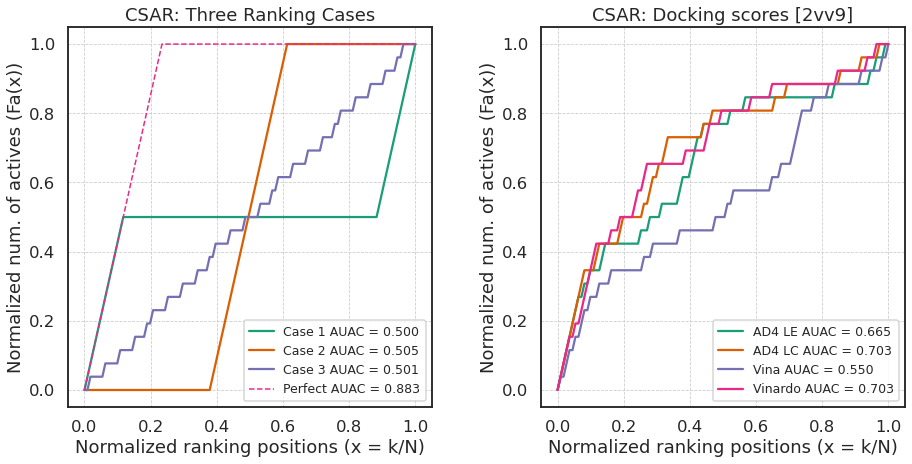

In [16]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_cases.plot_auac(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                     fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
csar_dockings.plot_auac(title='CSAR: Docking scores [2vv9]', key_to_fade = 'Perfect',
                    fontsize='x-small', show_by_itself = False)
plt.show();

### AUAC DUD

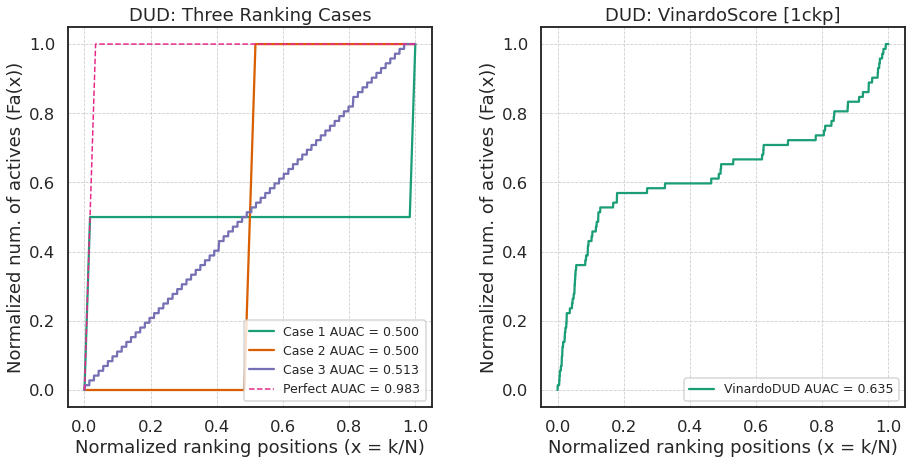

In [17]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
dud_cases.plot_auac(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                     fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_auac(title=F'DUD: VinardoScore [{pdb_id_dud}]', key_to_fade = 'Perfect',
                    fontsize='x-small', show_by_itself = False)
plt.show();

In [18]:
print('AUAC CSAR')
csar_cases.format_metric_results('auac', transposed=False)
print('AUAC DUD')
dud_cases.format_metric_results('auac', transposed=False)

AUAC CSAR


,Case 1,Case 2,Case 3,Perfect
AUAC,0.5,0.505,0.501,0.883


AUAC DUD


,Case 1,Case 2,Case 3,Perfect
AUAC,0.5,0.5,0.513,0.983


**NOTA**: En las gráficas de resultados de docking, la gráfica de CSAR corresponde a la evaluación de los ligandos de CSAR para el que se emplearon 4 métodos de docking. Para el caso de las gráficas de DUD sólo se tienen resultados de docking con Vinardo.

***
<h1 class='text-danger'>AUC-ROC: <span class="text-muted">Receiver Operating Characteristic</span>
</h1><div style='background-color: #F9E5AB; min-height: 10px'></div>

- Es una de las métricas más usadas para evaluar el desempeño de un VS.

- El valor de AUC de ROC va de 0 (peor desempeño) a 1 (mejor desempeño). Y cuando el AUC = 0.5, el ranking es equivalente a una selacción aleatoria entre activos e inactivos, mostrando una distribución uniforme entre estas dos clases.

- <div style='background-color: #C6FCDE; padding: 5px 12px;'>El valor del AUC-ROC puede interpretarse como la probabilidad de un activo sea encontrado antes que un inactivo en el *ranking* dado.</div>
    
De forma continua se calcula de la siguiente manera:

> $
\begin{aligned}
ROC = \int _{0}^{1} F_a(x) \dot f_i(x) dx
\end{aligned}
$

> donde $f_i(x)$ es la PDF de inactivos en el *ranking*. Es decir, el $AUC ROC$ se obtiene a partir del producto de la CDF de los activos por la PDF de los inactivos.
- A diferencia de $AUAC$, aquí $f(x) = f_i(x) \neq 1$.


De forma numérica, es calculado de la siguiente manera (para *rankings* de scores):

> $
\begin{aligned}
ROC = \frac{1}{n(N-n)}\sum_{k = 2}^{N}F_a (k) *[F_i(k) - F_i(k - 1)] 
\end{aligned}
$

> donde $n$ es el número de moléculas activas (Positivos), $N$ es el total de moléculas evaluadas, $F_a(k)$ y $F_i(k)$ es la cuenta acumulada de activos e inactivos, respectivamente, hasta la posición $k$ del ranking. 

El valor normalizado de $F_a(k)$ es $F_a(x) = F_a(k) / n$. Es decir, $F_a(k)$ es la **tasa de verdaderos positivos o Sensibilidad** ($TP/P$). Por su parte, $F_i(x) = F_i(k) / (N-n)$, corresponde a la **tasa de falsos positivos** ($FP/N$).

> $
\begin{aligned}
ROC  = \sum_{i = 2}^{N} F_a (x_i) *[F_i(x_{i}) - F_i(x_{i-1})] \\
     = \sum_{k = 2}^{N} TPR_{k} * (FPR_{k} - FPR_{k-1}) \\
\end{aligned}
$

> donde $TPR_k = \frac{F_a(k)}{n}$ y $FPR_k = \frac{F_i(k)}{N-n}$ son la tasa de verdaderos positivos y la tasea falsos positivos hasta la posición $k$ del *ranking*, respectivamente.

- En la práctica, lo anterior equivale a pensar que, al ir recorriendo cada posición $k$ del rango, cuando el delta de $\Delta FPR_k$ es igual a 0, $TPR_k$ aumenta $1/n$, pero el $AUC$ se mantiene constante. Y cuando $\Delta FPR_k \neq 0$, implica que el $FPR$ aumenta y nos movemos un paso (de tamaño $1/(N-n)$), lo que aumenta el valor de AUC; $AUC_k = AUC_{k-1} + (1/(N-n)) * TPR_k$.

- **ROC** no puede discriminar entre los tres casos propuestos.

### ROC con CSAR

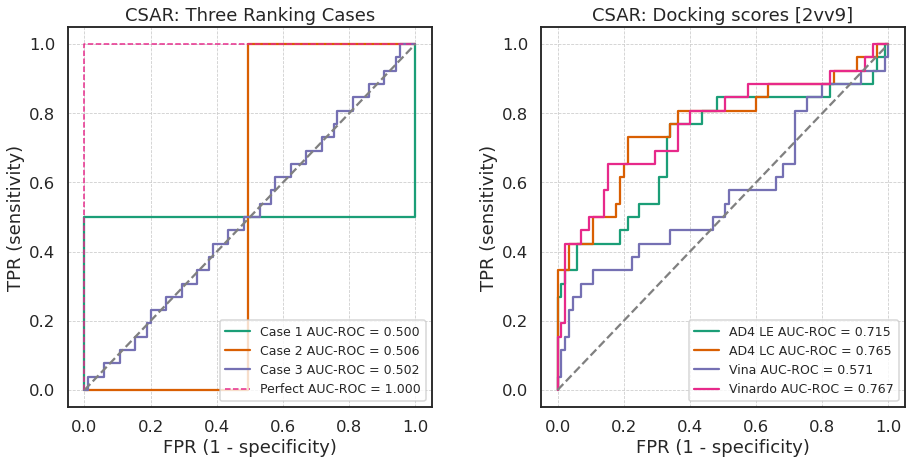

In [19]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_cases.plot_roc_auc(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                     fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
csar_dockings.plot_roc_auc(title='CSAR: Docking scores [2vv9]', key_to_fade = 'Perfect',
                    fontsize='x-small', show_by_itself = False)
plt.show();

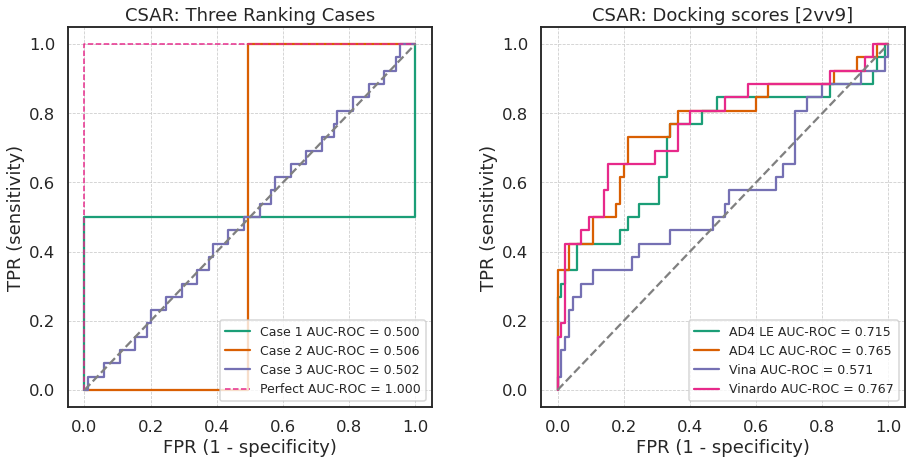

In [20]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_cases.plot_roc_auc(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                     fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
csar_dockings.plot_roc_auc(title='CSAR: Docking scores [2vv9]', key_to_fade = 'Perfect',
                    fontsize='x-small', show_by_itself = False)
plt.show();

### ROC con DUD

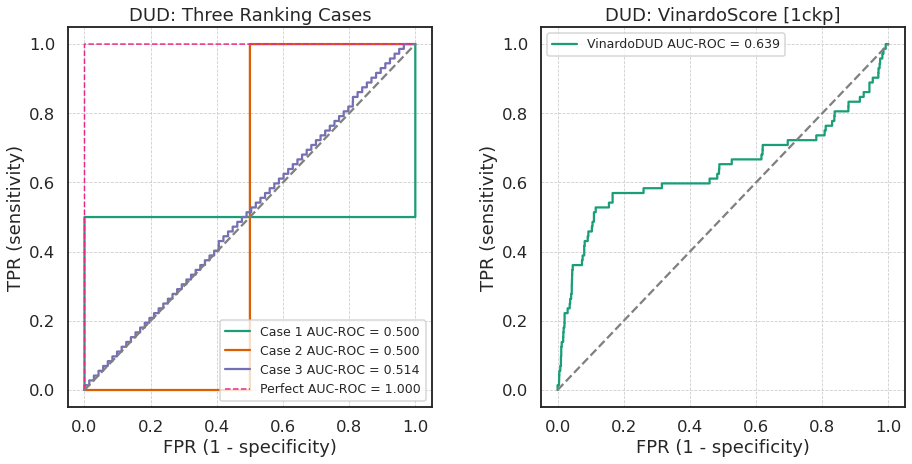

In [21]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
dud_cases.plot_roc_auc(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                     fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_roc_auc(title=F'DUD: VinardoScore [{pdb_id_dud}]', key_to_fade = 'Perfect',
                    fontsize='x-small', show_by_itself = False)
plt.show();

In [22]:
print('ROC-AUC CSAR')
csar_dockings.format_metric_results('roc_auc', transposed=False)
print('ROC-AUC DUD')
dud_dockings.format_metric_results('roc_auc', transposed=False)

ROC-AUC CSAR


,AD4 LE,AD4 LC,Vina,Vinardo
ROC AUC,0.715,0.765,0.571,0.767


ROC-AUC DUD


,VinardoDUD
ROC AUC,0.639


### Desventajas de ROC-AUC

- ROC-AUC no es una buena métrica para el VS, pues no permite abordar el problema de '*early recognition*'. Es decir, al tomar en cuenta toda la distribución de activos en el *ranking*, ROC-AUC no es capaz de distinguir *rankings* que podrían ser más convenientes en procedimiento de VS, donde la prioridad no es realmente rankear todos los posibles activos en la primer parte del ranking, sino garantizar que al menos una pequeña proporción de los activos quede al principio (en el *top*) del *ranking*. Pues, en la práctica, sólo una pequeña proporción de los compuestos rankeados será evaluada experimentalmente.
- Turchon y Bayly muestran además que en realidad si hay una dependencia de la métrica con respecto a la proporción de activos/inactivos.

<h1 class='text-danger'>pROC: <span class="text-muted">log-scale ROC Curve</span>
</h1><div style='background-color: #F9E5AB; min-height: 10px'></div>

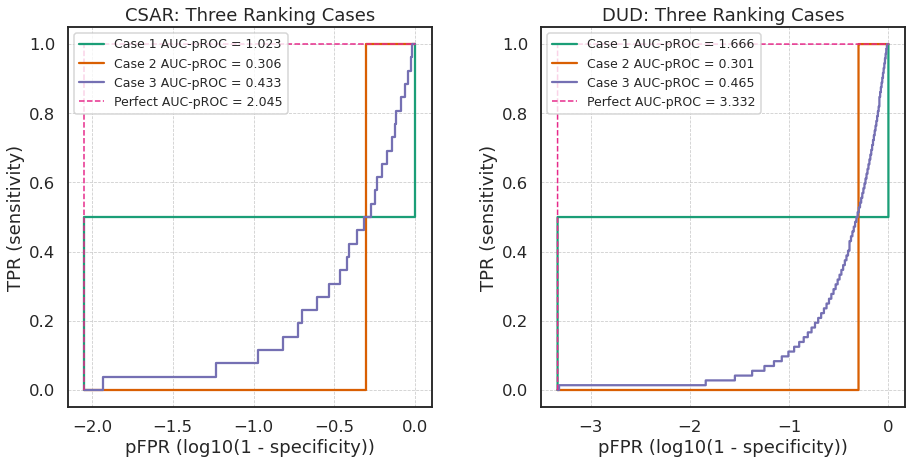

In [23]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_cases.plot_pRoc_auc(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                        fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_cases.plot_pRoc_auc(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.show();

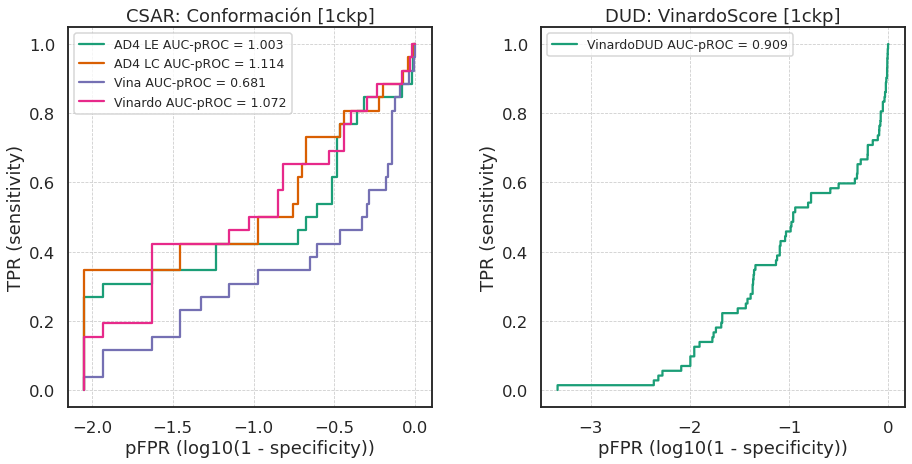

In [24]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
csar_dockings.plot_pRoc_auc(title=F'CSAR: Conformación [{pdb_id_dud}]',
                        fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_pRoc_auc(title=F'DUD: VinardoScore [{pdb_id_dud}]',
                       fontsize='x-small', show_by_itself = False)
plt.show();

***
<h1 class='text-danger'>Precision and Recall: <span class="text-muted">Area Under Precision and Recall Curve</span>
</h1>
<div style='background-color: #F9E5AB; min-height: 10px'></div>

- La Curva de Presición y Sensibilidad, y su área bajo la curva (AUC[PR]), no es abordada por Truchon y Bayley. Sin embargo, es mecionada por otros autores (Liu, *et al.*, 2019) como una alternativa para medir el desempeño del VS.
- Es recomendado para problemas con imbalance de clases.
- Se suele utilizar para visualizar el *trade-off* entre la precisión y la sensibilidad de un clasificador binario.

- El AUC es dependiente de $R_a$. Y en una distribución aleatoria el valor de la precisión ($TP/(TP + FP)$) decae hasta $R_a$ cuando la Sensibilidad ($TP/P$) tiende a 1.0.
- $AUC[PR]$ sí logra discriminar entre los tres casos mencionados por Truchon y Bayley (2007).

### PR con CSAR

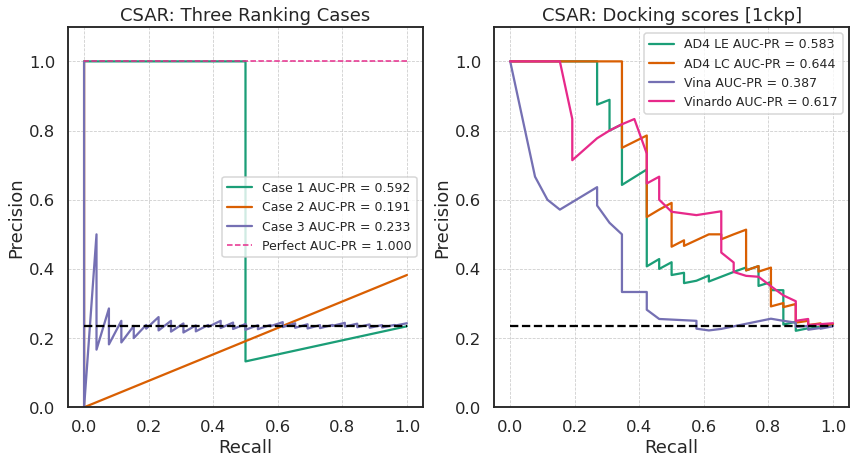

In [25]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_pr_auc(title='CSAR: Three Ranking Cases', key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
csar_dockings.plot_pr_auc(title=F'CSAR: Docking scores [{pdb_id_dud}]', key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

### PR con DUD

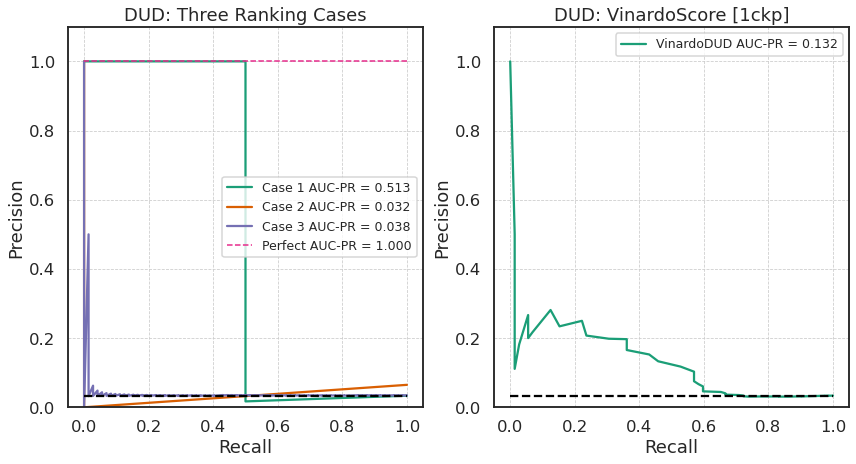

In [26]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
dud_cases.plot_pr_auc(title='DUD: Three Ranking Cases', key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_pr_auc(title=F'DUD: VinardoScore [{pdb_id_dud}]', key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

In [27]:
print('Precision/Recall AUC CSAR')
csar_dockings.format_metric_results('pr_auc', transposed=False)
print('Precision/Recall DUD')
dud_dockings.format_metric_results('pr_auc', transposed=False)

Precision/Recall AUC CSAR


,AD4 LE,AD4 LC,Vina,Vinardo
PR AUC,0.583,0.644,0.387,0.617


Precision/Recall DUD


,VinardoDUD
PR AUC,0.132


**NOTA:** Los resultados no son comparables entre datasets de diferentes tamaños debido a que el valor de Precisión final depende de $R_a$.

***
<h1 class='text-danger'>EF: <span class="text-muted">Enrichment Factor</span>
</h1>
<div style='background-color: #F9E5AB; min-height: 10px'></div>

- <div style='background-color: #C6FCDE; padding: 5px 12px;'>El factor de enriquecimiento se basa determinar cuantas de las $n$ moléculas activas se encuentran dentro de una fracción inicial, de tamaño $\chi$, del *ranking* de los valores predichos. </div>

- Esto permite resolver el problema de comparar resultados del clasificador sobre datasets con diferentes proporciones de activos e inactivos.  
**Pero que tenga el mismo número de moléculas $N$**.

- La idea es comparar qué tan enriquecido en activos está la primer fracción (de tamaño $\chi$) de **mi *ranking* de predichos**, con respecto al enriquecimiento de una fracción del mismo tamaño cuyos elementos se eligieron aleatoriamente.
- $EF$ sí puede discriminar entre los tres casos mencionados anteriormente.


- Del artículo de Truchon y Bayly:
> *This metric has the advantage of answering the question: how enriched in actives will the set of 300 compounds that I select for screening be compared to the case where I would just pick the 300 compounds randomly? This is relevant only if the database is of considerable size (N > 300).*

La fórmula que presentan Truchon y Bayly es la siguiente:

> $
\begin{align}
EF_{\chi} = \frac{1}{\chi n}\sum_{i=1}^{n}\delta _i
\end{align}
$

donde $EF_{\chi}$ es el factor de enriquecimiento en la proporción $\chi$, $n$ es el número total de activos, y:
> - $\delta _i = 1$ si $r_i \leq \chi N$
- $\delta _i = 0$ si $r_i > \chi N$  
donde $r_i$ es la posición del activo $i$ en el ranking de los predichos.

Por lo tanto, $\sum_{i=1}^{n}\delta _i = n_s$, donde $n_s$ representa al número de moléculas activas dentro de las  $N_s =  \left \lfloor{\chi N}\right \rfloor $ moléculas del ranking:

> $
\begin{align}
EF_{\chi} = \frac{n_s}{\chi n}
\end{align}
$

Como $\chi = N_s/N$, llegamos al a fórmula mencionada por Lopes, *et al.*:

> $
\begin{align}
EF_{\chi} = \frac{n_s}{\chi n} = \frac{n_s*N}{N_s*n}
\end{align}
$

Otra manera de plantearlo es la siguiente:

> $
\begin{align}
EF_{X\%} = \frac{\textrm{# de activos a un X%}} {\textrm{# de moléculas a un X%}} * \frac{N}{n}
\end{align}
$

### Características del EF

- $\chi$ (o $X\%$) debe ser establecido por el investigador.

- El valor máximo que puede tomar es $1/\chi$ si $\chi \geq n/N$, o $N/n$ si $\chi < n/N$.Y su valor mínimo es 0.

- El valor medio de EF en una distribución uniforme se mantiene cercano a 1 ($\left \lfloor{\chi N}\right \rfloor/chi·N$).

### Desventajas:
- $EF$ se ve afectado por la proporción de activos en el *dataset* presentando un efecto de saturación. Con lo cual, cuando muy pocos activos en el dataset la métrica se vuelve muy sensible a pequeñas variaciones en las posiciones de los activos dentro de la fracción $\chi$.

- $EF$ además, otorga el mismo peso a los activos dentro de $N_s$, con lo cual no sería capaz de encontar diferencias entre los siguientes dos rankings de ejemplo:

> 1. (1, 1, 0, 0, 0 | ... ),  ranking 1 con $N_s = 5$ y $n_s = 2$
2. (0, 0, 0, 1, 1 | ... ),  ranking 2 con $N_s = 5$ y $n_s = 2$

- Esto se debe a que EF da el mismo peso a todos los ligandos activos que se encuentren dentro de la fracción $\chi$.

- Lo anterior dificulta que el $EF$ sea capaz de distinguir entre buenos clasificadores y excelentes clasificadores ([Truchon J-F, Bayly CI]()).

- EF además no tiene un valor máximo definido.

### EF con CSAR

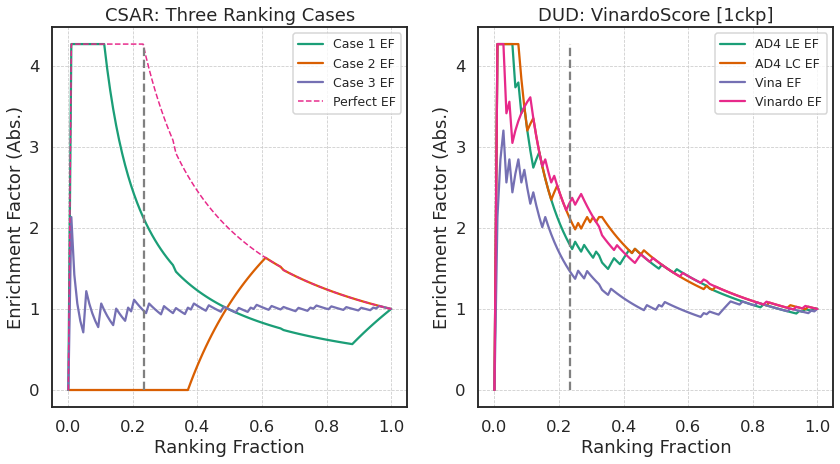

In [28]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_ef_auc(title='CSAR: Three Ranking Cases', method = 'absolute',
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
csar_dockings.plot_ef_auc(title=F'DUD: VinardoScore [{pdb_id_dud}]', method = 'absolute',
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

### EF con DUD

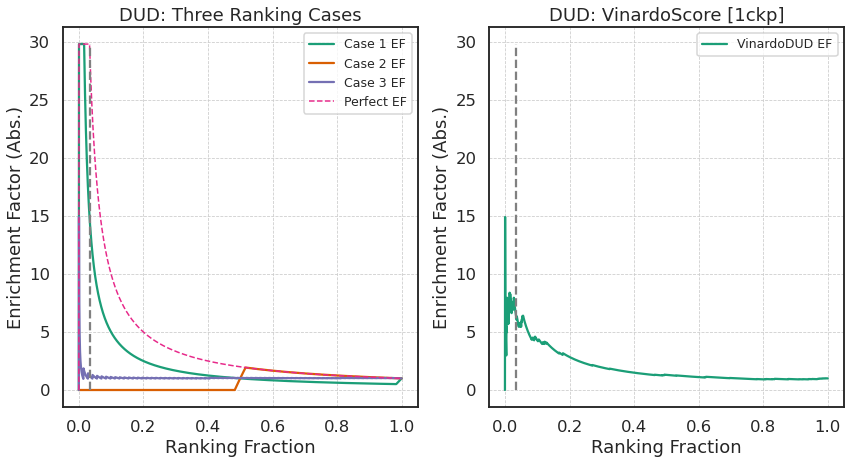

In [29]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
dud_cases.plot_ef_auc(title='DUD: Three Ranking Cases', method = 'absolute',
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_ef_auc(title=F'DUD: VinardoScore [{pdb_id_dud}]', method = 'absolute',
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

<h1 class='text-danger'>NEF: <span class="text-muted">Normalized Enrichment Factor</span>
</h1><div style='background-color: #F9E5AB; min-height: 10px'></div>

- [Liu, et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6351977/) y [Lopes, *et al.* (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5289935/) mencionan una alternativa para normalizar el valor de EF y limitar su valor entre 0 y 1:

> $
\begin{align}
NEF_{\chi} = \frac{EF}{EF_{max}}
= \frac{n_s/(n*\chi)}{min(N_s, n) / (n*\chi)} = \frac{n_s} {min(N_s, n)}
\end{align}
$

### NEF con CSAR

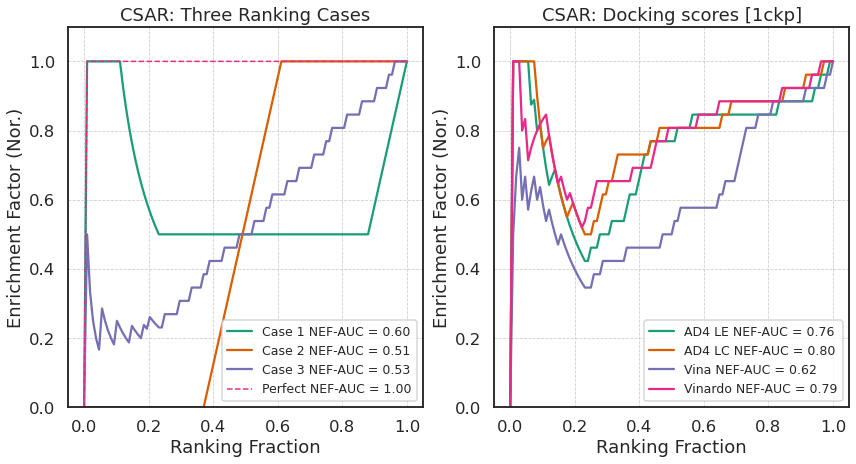

In [30]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_ef_auc(title='CSAR: Three Ranking Cases', method = 'normalized',
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
csar_dockings.plot_ef_auc(title=F'CSAR: Docking scores [{pdb_id_dud}]', method = 'normalized',
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

### NEF con DUD

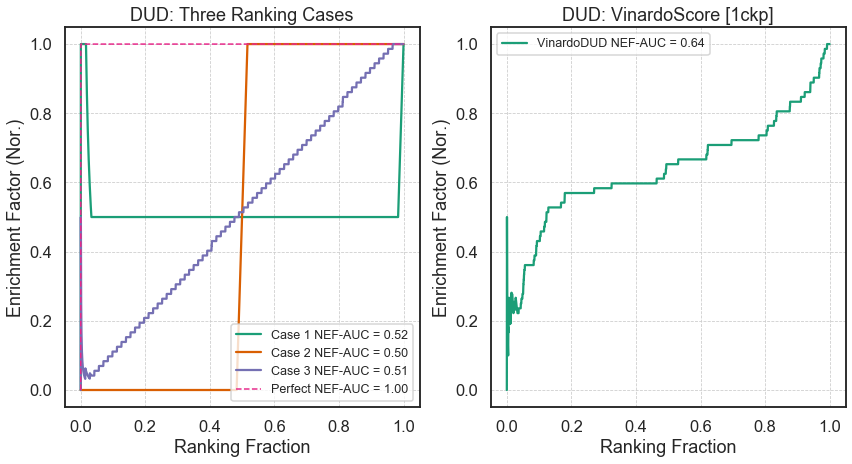

In [30]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
dud_cases.plot_ef_auc(title='DUD: Three Ranking Cases', method = 'normalized',
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_ef_auc(title=F'DUD: VinardoScore [{pdb_id_dud}]', method = 'normalized',
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

### Valores de NEF a un $\chi$ dado

In [31]:
print('Normalized Enrichment Factor CSAR')
fractions = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
csar_dockings.get_efs(method = 'normalized', fractions=fractions).T
print('Normalized Enrichment Factor DUD')
dud_dockings.get_efs(method = 'normalized', fractions=fractions)

Normalized Enrichment Factor CSAR


,AD4 LE,AD4 LC,Vina,Vinardo,#ligs at X%
NEF at 0.5%,0.00,0.00,0.00,0.00,0.0
NEF at 1.0%,1.00,1.00,0.50,1.00,1.0
NEF at 2.0%,1.00,1.00,0.67,1.00,2.0
NEF at 5.0%,1.00,1.00,0.67,0.83,5.0
NEF at 10.0%,0.75,0.75,0.58,0.83,11.0
NEF at 20.0%,0.48,0.57,0.39,0.57,22.0
NEF at 50.0%,0.77,0.81,0.50,0.81,55.0
NEF at 100%,1.00,1.00,1.00,1.00,111.0


Normalized Enrichment Factor DUD


,NEF at 0.5%,NEF at 1.0%,NEF at 2.0%,NEF at 5.0%,NEF at 10.0%,NEF at 20.0%,NEF at 50.0%,NEF at 100%
VinardoDUD,0.18,0.23,0.23,0.28,0.43,0.57,0.65,1.0
#ligs at X%,10.00,21.00,42.00,107.00,214.00,429.00,1073.00,2146.0


## NEF: Limitando la fracción evaluada

En las siguientes gráficas sólo se obtiene EF hasta $\chi = 0.2$.

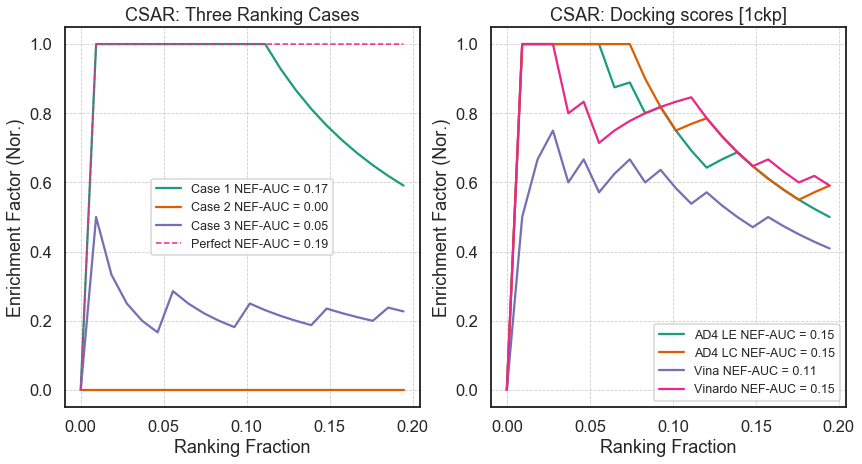

In [32]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_ef_auc(title='CSAR: Three Ranking Cases', 
                       method = 'normalized', max_chi = 0.2,
                       key_to_fade = 'Perfect',
                       fontsize='x-small', show_by_itself = False)
plt.subplot(1,2,2)
csar_dockings.plot_ef_auc(title=F'CSAR: Docking scores [{pdb_id_dud}]', 
                      method = 'normalized', max_chi = 0.2,
                      key_to_fade = 'Perfect',
                      fontsize='x-small', show_by_itself = False)
plt.show();

***

<h1 class='text-danger'>RIE: <span class="text-muted">Robust Initial Enhancement</span></h1>
<div style='background-color: #F9E5AB; min-height: 10px'></div>

- RIE es una métrica desarrolada por Sheridan, *et al* (2001). **Se basa en decrementar el peso que tiene cada uno de los activos en el *ranking* de predichos conforme se alejan de las posiciones iniciales.** Por lo tanto, el peso de cada activo en el valor final de la métrica depende de $r_i$. Así, los activos que aparecen más pronto en el rango ('*early recognition*') tienen mayor peso en valor de la métrica.


- Para el valor de los pesos se utiliza una función exponencial. Los autores escogieron una función exponencial sobre una logistica o gaussiana debido a lo siguiente:
    1. La logística tendería a comportarse como $EF$, al bruscamente valorar con más a los activos dentro de la fracción del *ranking* definida por $\alpha$ (recordando que $1/\alpha = \chi$).
    2. La importancia del peso hasta cierta fracción del *ranking* puede ser controlada con el parámetro $\alpha$.


- Al dar peso a todos los activos, $RIE$ tiene la ventaja sobre $EF$ de incluir la contribución de todos los activos en el score final (aunque mermando el peso de los activos que tienen posiciones más bajas en el *ranking*) .

- Es menos suceptible que $EF$ a tener grandes variaciones cuando la proporción de activos es muy baja.

La formula inicialmente propuesta es:

> $
\begin{align}
RIE = \frac{\sum_{i=1}^n e^{-\alpha r_i / N}} {\langle\sum_{i=1}^n e^{-\alpha r_i / N} \rangle_r},
\end{align}
$


> donde $n$ es el número de activos, $N$ es el número total de moléculas, $r_i$ es la posición en el ranking (el rango) de la $i^{th}$ molécula activa en la lista ordenada de *predichos*. En este caso, $r_i / N$ es expresado como $x_i$; el rango normalizado. Finalmente $\alpha$ es un hiperparámetro relacionado con $\chi$ del $EF$ ($1/\alpha \approx \chi$).

En la ecuación anteriror, **el denominador es el promedio de la suma del exponencial cuando un número $n$ de activos  está uniformemente distribuido en $N$ moléculas**. Este término inicialmente era calculado con MonteCarlo, pues obtenerlo por fuerza bruta implicaba tomar en cuenta las $N!/(N-n)!n!$ combinaciones posibles. No obstante,  Truchon y Bayly proponen la siguiente formula para calcular $RIE$:

> $
\begin{align}
RIE = \frac{\sum_{i=1}^n e^{-\alpha r_i / N}} {\frac{n}{N} \left( \frac{1 - e^{-\alpha}}{e^{\alpha / N} - 1}\right) },
\end{align}
$

> donde el nuevo denominador fue determinado por Truchon y Bayly de forma analítica para aproximarse al término de la primera ecuación.

- La representación contínua de esta función es la siguiente:

> $
\begin{align}
RIE = \frac{\int_{0}^{1} f_a(x) \ e^{- \alpha x}}{1/\alpha(1 - e^{- \alpha})},
\end{align}
$

> donde el numerador es la FDP exponencial de los activos, y el denominador es el valor medio del exponencia len una distribución uniforme, ambos definidos por $\alpha$. Este último término evita que $RIE$ esté acotado dentro de 0 y 1.

- La ecuación anterior proviene de una generalización de la ecuación de $AUAC$ a la que se le han asignado pesos dependiendo del valor de la posición de los activos en el *ranking*:

> $
\begin{align}
wAUAC = \frac{\int_{0}^{1} F_a(x) \ w(x)dx}{\int_{0}^{1} w(x) dx} = ,
\end{align}
$

- Sus valores mínimos y máximos dependen de $n$, $N$ y $\alpha$, con lo cual no permite comparaciones con *datasets* de diferentes tamaños, como sí lo hace $EF$.

- En resumen, $RIE$ tiene mayor ventaja que $ROC-AUC$ al abordar el problema de *early recognition*, y más ventaja sobre $REF$ al incluir la contribución de activos en todo el *ranking*, y no sólo en la fracción elegida. No obstante, si se van a comparar resultados con *datasets* de distinta proporción de activos/inactivos, $REF$ es una mejor opción.

Fuentes: https://sci-hub.tw/10.1021/ci600426e
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-10-225

### Valores de RIE a difernetes valores de $\alpha$

In [33]:
print('RIE CSAR')
alphas = [50.0, 30.0, 20.0, 15.0, 10.0, 4.2, 4.0, 2.0, 1.0, 0.01]
print('Three Cases')
csar_cases.get_bedrocs(alphas=alphas)
print('Docking Scores')
csar_dockings.get_bedrocs(alphas=alphas)

RIE CSAR
Three Cases


,alpha = 50.0,alpha = 30.0,alpha = 20.0,alpha = 15.0,alpha = 10.0,alpha = 4.2,alpha = 4.0,alpha = 2.0,alpha = 1.0,alpha = 0.01
Case 1,0.997,0.971,0.912,0.853,0.763,0.621,0.615,0.558,0.529,0.500
Case 2,0.000,0.000,0.001,0.003,0.022,0.171,0.182,0.323,0.411,0.505
Case 3,0.258,0.245,0.238,0.239,0.254,0.339,0.345,0.414,0.457,0.501
Perfect,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


Docking Scores


,alpha = 50.0,alpha = 30.0,alpha = 20.0,alpha = 15.0,alpha = 10.0,alpha = 4.2,alpha = 4.0,alpha = 2.0,alpha = 1.0,alpha = 0.01
AD4 LE,0.972,0.903,0.818,0.754,0.685,0.653,0.654,0.678,0.696,0.716
AD4 LC,0.985,0.931,0.857,0.801,0.741,0.713,0.714,0.733,0.748,0.765
Vina,0.673,0.630,0.587,0.553,0.513,0.494,0.496,0.520,0.540,0.564
Vinardo,0.913,0.848,0.793,0.756,0.717,0.706,0.708,0.730,0.746,0.765


In [34]:
print('RIE DUD')
alphas = [50.0, 30.0, 20.0, 15.0, 10.0, 4.2, 4.0, 2.0, 1.0, 0.01]
print('Three Cases')
dud_cases.get_bedrocs(alphas=alphas)
print(F'DUD: VinardoScore [{pdb_id_dud}]')
dud_dockings.get_bedrocs(alphas=alphas)

RIE DUD
Three Cases


,alpha = 50.0,alpha = 30.0,alpha = 20.0,alpha = 15.0,alpha = 10.0,alpha = 4.2,alpha = 4.0,alpha = 2.0,alpha = 1.0,alpha = 0.01
Case 1,0.698,0.623,0.583,0.563,0.542,0.518,0.517,0.508,0.504,0.500
Case 2,0.000,0.000,0.000,0.001,0.008,0.116,0.126,0.276,0.381,0.499
Case 3,0.055,0.063,0.077,0.093,0.125,0.246,0.255,0.364,0.435,0.513
Perfect,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


DUD: VinardoScore [1ckp]


,alpha = 50.0,alpha = 30.0,alpha = 20.0,alpha = 15.0,alpha = 10.0,alpha = 4.2,alpha = 4.0,alpha = 2.0,alpha = 1.0,alpha = 0.01
VinardoDUD,0.259,0.293,0.33,0.36,0.405,0.501,0.506,0.566,0.602,0.639


***
<h1 class='text-danger'>BEDROC: <span class="text-muted">Boltzmann-Enhanced Discrimination of ROC Metric</span></h1>
<div style='background-color: #F9E5AB; min-height: 10px'></div>

- <div style='background-color: #C6FCDE; padding: 5px 12px;'>El valor de BEDROC se puede interpretar como la probabilidad de que un activo rankeado por un método de scoring sea encontrado antes que un compuesto que proviende de una Función de Distribución de Probabilidad exponencial hipotética definida por el parámetro $\alpha$. Pero sólo bajo la condición de que $\alpha*R_a << 1$ y $\alpha \neq 0$.</div>

- Del lso autores:
> *BEDROC should be understood as a “virtual screening
usefulness scale” as opposed to an “improvement over
random scale” (ROC)*

- $BEDROC$, de hecho, es un **escalamiento min-max de $RIE$**:

> $
\begin{align}
BEDROC = \frac{RIE - RIE_{min}}{RIE_{max} - RIE_{min}},
\end{align}
$

- El valor de BEDROC va desde 0 a 1.

- <span style='color: red; font-weight: bold'>Comparar valores BEDROC con diferentes valores $\alpha$ no es correcto, al igual que no es correcto comparar valores $EF$ al variar el parámetro $\chi$.
    </span>

### Valores de BEDROC a difernetes valores de $\alpha$

### Casos de CSAR

In [35]:
print('BEDROC')
alphas = [50.0, 30.0, 20.0, 15.0, 10.0, 4.2, 4.0, 2.0, 1.0, 0.01]
csar_cases.get_bedrocs(alphas=alphas)

BEDROC


,alpha = 50.0,alpha = 30.0,alpha = 20.0,alpha = 15.0,alpha = 10.0,alpha = 4.2,alpha = 4.0,alpha = 2.0,alpha = 1.0,alpha = 0.01
Case 1,0.997,0.971,0.912,0.853,0.763,0.621,0.615,0.558,0.529,0.500
Case 2,0.000,0.000,0.001,0.003,0.022,0.171,0.182,0.323,0.411,0.505
Case 3,0.258,0.245,0.238,0.239,0.254,0.339,0.345,0.414,0.457,0.501
Perfect,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


#### Los datos de las tablas anteriores vistos gráficamente


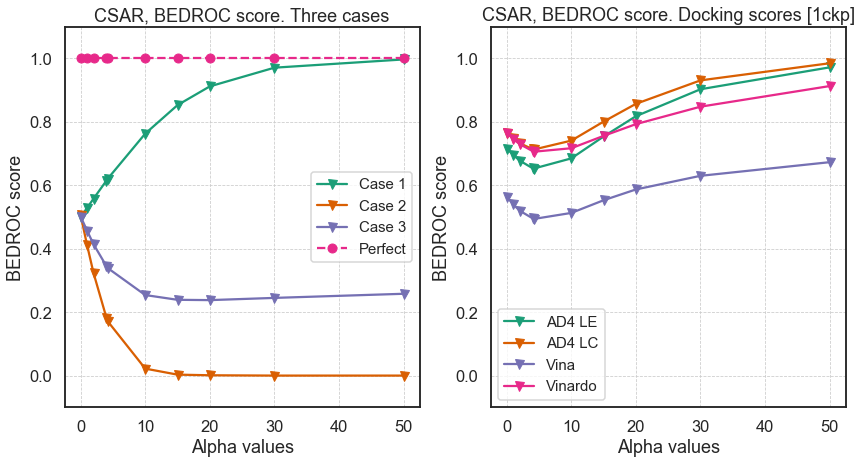

In [36]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
csar_cases.plot_bedroc(title = 'CSAR, BEDROC score. Three cases', 
                       alphas=alphas, key_to_fade = 'Perfect',
                      show_by_itself = False)
plt.subplot(1,2,2)
csar_dockings.plot_bedroc(title = F'CSAR, BEDROC score. Docking scores [{pdb_id_dud}]', 
                          alphas=alphas,  show_by_itself = False)
plt.show();

### Casos de DUD

In [37]:
print(F'BEDROC DUD: VinardoScore [{pdb_id_dud}]')
dud_dockings.get_bedrocs(alphas=alphas)

BEDROC DUD: VinardoScore [1ckp]


,alpha = 50.0,alpha = 30.0,alpha = 20.0,alpha = 15.0,alpha = 10.0,alpha = 4.2,alpha = 4.0,alpha = 2.0,alpha = 1.0,alpha = 0.01
VinardoDUD,0.259,0.293,0.33,0.36,0.405,0.501,0.506,0.566,0.602,0.639


#### Los datos de las tablas anteriores vistos gráficamente


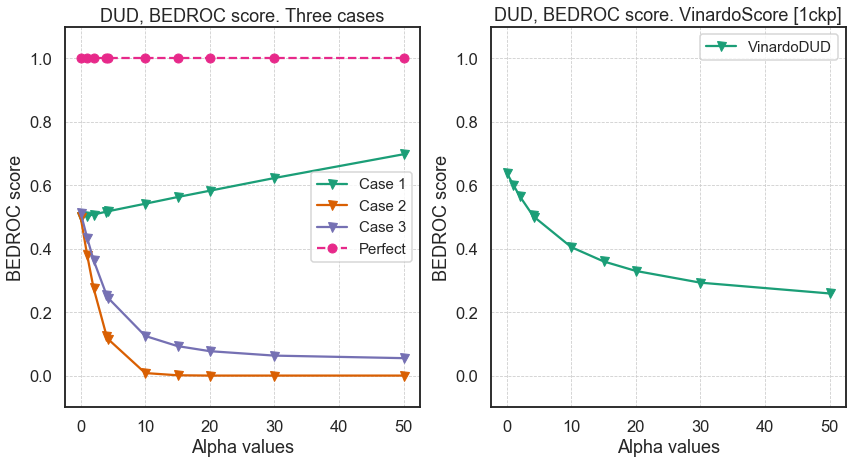

In [38]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
dud_cases.plot_bedroc(title = 'DUD, BEDROC score. Three cases', 
                       alphas=alphas, key_to_fade = 'Perfect',
                      show_by_itself = False)
plt.subplot(1,2,2)
dud_dockings.plot_bedroc(title = F'DUD, BEDROC score. VinardoScore [{pdb_id_dud}]', 
                          alphas=alphas, show_by_itself = False)
plt.show();